In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI(model_name="gpt-4o-mini")

In [4]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative', 'neutral'] = Field(description="The sentiment of the review")

In [14]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="List of issues mentioned in the review")
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description="Tone of the review")
    urgency: Literal["Low", "Medium", "High"] = Field(description="Urgency level of the review")

In [5]:
structured_model = model.with_structured_output(SentimentSchema)

In [15]:
structured_diagnosis_model = model.with_structured_output(DiagnosisSchema)

In [6]:
prompt = "What is the sentiment of the following review? Review: 'The product was excellent and met all my expectations.'"
structured_model.invoke(prompt)

SentimentSchema(sentiment='positive')

In [7]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str


In [ ]:
def find_sentiment(state: ReviewState) -> ReviewState:
    prompt = f"What is the sentiment of the following review? Review: '{state['review']}'"
    result = structured_model.invoke(prompt).sentiment
    return {'sentiment': result}

def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

def positive_response(state: ReviewState):
    prompt = f"Write a warm thank you message in response to this review: \n\n {state['review']}.\nAlso, kindly ask the user to leave feedback on our website."
    response = model.invoke(prompt).content
    return {'response': response}

def run_diagnosis(state: ReviewState):
    prompt = f"Analyze the following negative review and provide issue_type, tone and urgency: '{state['review']}'"
    diagnosis = structured_diagnosis_model.invoke(prompt)
    return {'diagnosis': diagnosis.model_dump()}

def negative_response(state: ReviewState):
    prompt = f"""
You are a support assistant. The user had a '{state['diagnosis']['tone']}' tone in their review and the urgency level is '{state['diagnosis']['urgency']}'.
Based on the diagnosis '{state['diagnosis']}', draft a compassionate and helpful response to the following review: '{state['review']}'.
"""
    response = model.invoke(prompt).content
    return {'response': response}

In [ ]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')
graph.add_edge('find_sentiment', END)

workflow = graph.compile()

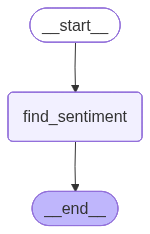

In [11]:
workflow

In [13]:
initial_state = {
    'review': "The product was bad and did not meet my expectations."
}
workflow.invoke(initial_state)

{'review': 'The product was bad and did not meet my expectations.',
 'sentiment': 'negative'}